# Predicting if Someone has Tried Cocaine
## Exploratory Data Analysis

In [1]:
import pandas as pd 
import pickle
import numpy as np 
import matplotlib.pyplot as plt 

# Importing our Data

We have a large dataset, so we're going to choose specific columns to extract. Each column is a code in the NSDUH Survey Documentation, which can be found here:

https://www.datafiles.samhsa.gov/sites/default/files/field-uploads-protected/studies/NSDUH-2002-2018/NSDUH-2002-2018-datasets/NSDUH-2002-2018-DS0001/NSDUH-2002-2018-DS0001-info/NSDUH-2002-2018-DS0001-info-codebook.pdf

A variety of continuous, ordinal, and categorical data was chosen, such as sex, highest completed education, total days consumed alcohol, etc. The results of each survey question is represented as a code. For example, "newrace2" contains the following codes to represent categorical data:

1. 1 = NonHisp White
2. 2 = NonHisp Black/Afr Am
3. 3 = NonHisp Native Am/AK Native
4. 4 = NonHisp Native HI/Other Pac Isl
5. 5 = NonHisp Asian
6. 6 = NonHisp more than one race
7. 7 = Hispanic

In [4]:
# Columns we will be extracting
cols = [
    "crkever",
    "cocever",
    "iralcfy",
    "catag3",
    "health",
    "irwrkstat",
    "ireduhighst2",
    "newrace2",
    "irsex",
    "irpinc3",
    "irki17_2",
    "irmjfy",
    "wrkdhrswk2",
    "irhhsiz2",
    "cig30use",
    "irherfy",
    "irmethamyfq",
    "year"
]

In [5]:
# Because our dataset is large, we will read our data in chunks. Each chunk is stored in chunk_list
chunk_list = []

# Read the csv we exported from our R script into a pandas dataframe
for chunk in pd.read_csv("datasets/NSDUH_2015-2019.csv", index_col=False, usecols=cols, chunksize=1000):
    chunk_list.append(chunk)

# Concatenate all chunks, then delete our chunk_list to preserve memory
df = pd.concat(chunk_list, axis=0)
del chunk_list

In [6]:
# Take a brief look at our data and its shape
df

,cig30use,cocever,crkever,iralcfy,irmjfy,irherfy,irmethamyfq,health,irsex,ireduhighst2,catag3,newrace2,wrkdhrswk2,irwrkstat,irhhsiz2,irki17_2,irpinc3,year
0,93,2,91,5,991,991,991,2,1,7,1,1,999,4,1,2,1,2015
1,93,1,1,52,364,991,991,1,1,8,4,7,40,1,4,3,2,2015
2,91,2,91,48,991,991,991,2,2,11,3,1,999,4,1,1,1,2015
3,91,2,91,2,991,991,991,3,2,4,1,7,999,99,5,4,1,2015
4,22,2,91,6,991,991,991,3,2,9,2,1,999,4,4,3,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282763,93,2,91,104,2,991,991,2,2,9,2,7,40,1,2,1,3,2019
282764,91,2,91,10,993,991,991,2,2,11,3,5,26,2,2,1,2,2019
282765,91,2,91,991,991,991,991,2,1,4,1,1,999,99,6,3,1,2019
282766,91,2,91,1,993,991,991,2,2,11,1,7,999,3,6,4,1,2019


In [7]:
# Check if there is currently any NaN values in our dataset
df.isna().sum()

cig30use        0
cocever         0
crkever         0
iralcfy         0
irmjfy          0
irherfy         0
irmethamyfq     0
health          0
irsex           0
ireduhighst2    0
catag3          0
newrace2        0
wrkdhrswk2      0
irwrkstat       0
irhhsiz2        0
irki17_2        0
irpinc3         0
year            0
dtype: int64

# Data Cleaning

No dataset is perfect. Our NSDUH documentation shows that several of our columns contain special codes equivalent to NaN (such as the 85 == BAD DATA codes in "cocever") or essentially equate to 0 (such as 991 == "Have never drank alcohol" for "iralcfy). So we will have to clean our data according to the NSDUH documentation codes if we want to explore trends in the data.

In [8]:
# Create a copy df that we will modify for cleaning
df2 = df.copy(deep=True)

# Look at the unique values in each column, confirming that special codes exist in our data
for i, col in zip(range(len(cols)), cols):
    print(col)
    print(df2[cols[i]].unique())
    print("========================")

crkever
[91  1  2 94 97 98 85]
cocever
[ 2  1 97 94 85]
iralcfy
[  5  52  48   2   6 120  84 991  12  24 993  14  96   3 360 260 144 156
 340 336 104   7  29  36 350 208 312   1  32 338  30 168 364   4  60  72
 363 365  40  51 353  20   9  15   8  10 180 240  26  53 339  19 345 288
  11 300 108  90 216 361  61  21  25 341  13 196  83 228  18  50  58  45
  22 362 250  42  17 342  44 357 276  28 358  70  89  43  35 100 351 344
 210 355  49 192  78 141  64 275 110  80  47 150  27 200 133  16  67 132
 106  46  79 297 324  75  34 145  56  23 280  97  31 313 261 204 359 264
 165 252 348  38 337 325 138 153  95  87 356 160  33 179  94  39 347 187
 171  55  65 117 157  71 155 164 176 343  74 140 290  62 220 265 190  91
 102 126 151 121  66 105 109  59  68  73 119 123  37  41 256  54 235  63
 175 111  57 330 112  98 268 149  93 195  92 274 225 285 241 143 166 212
 147 103 230 163 349  69 287 118 214 270  86  88 320 248 101 124 206 139
  99 170 181 334  85  82 335 186 239 185 221 137 130 255 259

The data codes for certain columns differ from others. Continuous data columns tend to use three-digit special codes, whereas ordinal and categorical variables use two-digit codes. We will create two separate functions to avoid cleaning meaningful data from the continuous columns.

In [9]:
cont_cols = [
    "iralcfy",
    "irmjfy",
    "wrkdhrswk2",
    "irherfy",
    "irmethamyfq"
]

ord_cols = [x for x in cols if x not in cont_cols]

# Function that cleans continuous numerical data counting by year
def cont_clean_data(x):

    # Survey codes for "Bad Data", Don't Know, Skip, Refused, or Blank
    if ((x == -9) |
    (x == 985) |
    (x == 989) |
    ((x >= 994) & (x < 1000))):
        return np.nan

    # Codes for "Have never done..." or "Have not done in the past X days"
    # Equivalent to 0 for numbered questions
    if ((x == 991) | 
    (x == 993)):
        return 0

    # Ignore value if conditions don't match
    return x 

# Function that cleans all other special data codes
def ord_clean_data(x):

    # Survey codes for "Bad Data", Don't Know, Skip, Refused, or Blank
    if ((x == -9) |
    ((x >= 94) & (x < 100)) |
    (x == 85) |
    (x == 89)):
        return np.nan

    # Codes for "Have never done..." or "Have not done in the past X days"
    # Equivalent to 0 for numbered questions
    if ((x == 91) |
    (x == 93)):
        return 0

    # Ignore value if conditions don't match
    return x 

There are some special situations that need to be accounted for before applying our clean_data function. These situations are as follows:

### wrkdhrsw2

Does not specify "0 hours worked", but we have irwrkstat, which specifies "Unemployed" or "Not in work force" for irwrkstat = 3 or 4. We can use irwrkstat to create 0 values for wrkhrsw2, as logically, someone who is unemployed or not in the work force would work 0 hours per week.

Additionally, people who work 61 hours or more are all pooled into wrkdhrsw2 = 61. If we want to maintain the continuous structure of wrkhrsw2, we cannot include this, so we'll remove them by converting 61 into np.nan values.

### impweeks

We will assume that if a respondent has skipped this question, it's because it does not apply to them. Therefore, skip values 89 and 99 should be converted to 0, for 0 weeks having difficulties with mental health.

### Binary Categorical Variables

We have a two binary categorical variables that need editing:

1. **cocever**: "Have you ever used cocaine before?"

2. **irsex** Sex of respondent

Right now, the codes are such that 1 = Yes, 2 = No. We want to change it to 1 = Yes and 0 = No, as this will be identical to categorical variables we will dummify later.

We will do this by matching these situations using df2.loc

In [26]:
# Changes for wrkdhrsw2
df2.loc[(df2.irwrkstat == 3) | (df2.irwrkstat == 4), "wrkdhrswk2"] = 0
df2.loc[df2.wrkdhrswk2 == 61, "wrkdhrswk2"] = np.nan

# Changes for binary categorical variables
df2.loc[(df2.cocever == 2), "cocever"] = 0
df2.loc[(df2.crkever == 2), "crkever"] = 0
df2.loc[(df2.irsex == 2), "irsex"] = 0

df2[cont_cols] = df2[cont_cols].applymap(cont_clean_data)
df2[ord_cols] = df2[ord_cols].applymap(ord_clean_data)

df2

,cig30use,cocever,crkever,iralcfy,irmjfy,irherfy,irmethamyfq,health,irsex,ireduhighst2,catag3,newrace2,wrkdhrswk2,irwrkstat,irhhsiz2,irki17_2,irpinc3,year,coccrkever
0,0.0,0.0,0.0,5,0,0,0,2.0,1,7,1,1,0.0,4.0,1,2,1,2015,0.0
1,0.0,1.0,1.0,52,364,0,0,1.0,1,8,4,7,40.0,1.0,4,3,2,2015,1.0
2,0.0,0.0,0.0,48,0,0,0,2.0,0,11,3,1,0.0,4.0,1,1,1,2015,0.0
3,0.0,0.0,0.0,2,0,0,0,3.0,0,4,1,7,NaN,NaN,5,4,1,2015,0.0
4,22.0,0.0,0.0,6,0,0,0,3.0,0,9,2,1,0.0,4.0,4,3,1,2015,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282763,0.0,0.0,0.0,104,2,0,0,2.0,0,9,2,7,40.0,1.0,2,1,3,2019,0.0
282764,0.0,0.0,0.0,10,0,0,0,2.0,0,11,3,5,26.0,2.0,2,1,2,2019,0.0
282765,0.0,0.0,0.0,0,0,0,0,2.0,1,4,1,1,NaN,NaN,6,3,1,2019,0.0
282766,0.0,0.0,0.0,1,0,0,0,2.0,0,11,1,7,0.0,3.0,6,4,1,2019,0.0


In [27]:
# Observe unique values in each column to ensure our changes
# are correct
for i, col in zip(range(len(cols)), cols):
    print(col)
    print(df2[cols[i]].unique())
    print("========================")

crkever
[ 0.  1. nan]
cocever
[ 0.  1. nan]
iralcfy
[  5  52  48   2   6 120  84   0  12  24  14  96   3 360 260 144 156 340
 336 104   7  29  36 350 208 312   1  32 338  30 168 364   4  60  72 363
 365  40  51 353  20   9  15   8  10 180 240  26  53 339  19 345 288  11
 300 108  90 216 361  61  21  25 341  13 196  83 228  18  50  58  45  22
 362 250  42  17 342  44 357 276  28 358  70  89  43  35 100 351 344 210
 355  49 192  78 141  64 275 110  80  47 150  27 200 133  16  67 132 106
  46  79 297 324  75  34 145  56  23 280  97  31 313 261 204 359 264 165
 252 348  38 337 325 138 153  95  87 356 160  33 179  94  39 347 187 171
  55  65 117 157  71 155 164 176 343  74 140 290  62 220 265 190  91 102
 126 151 121  66 105 109  59  68  73 119 123  37  41 256  54 235  63 175
 111  57 330 112  98 268 149  93 195  92 274 225 285 241 143 166 212 147
 103 230 163 349  69 287 118 214 270  86  88 320 248 101 124 206 139  99
 170 181 334  85  82 335 186 239 185 221 137 130 255 259 125 148 322 159

In [28]:
df2.isna().sum()

cig30use          550
cocever           116
crkever           133
iralcfy             0
irmjfy              0
irherfy             0
irmethamyfq         0
health             55
irsex               0
ireduhighst2        0
catag3              0
newrace2            0
wrkdhrswk2      55261
irwrkstat       33375
irhhsiz2            0
irki17_2            0
irpinc3             0
year                0
coccrkever          0
dtype: int64

# Creating our Target Column

In [29]:
df2['coccrkever'] = np.zeros(df.shape[0])
df2.loc[(df2.cocever == 1) | (df2.crkever == 1), "coccrkever"] = 1

df2.loc[(df2.cocever == np.nan) & (df2.crkever == np.nan), "coccrkever"] = np.nan
df2

,cig30use,cocever,crkever,iralcfy,irmjfy,irherfy,irmethamyfq,health,irsex,ireduhighst2,catag3,newrace2,wrkdhrswk2,irwrkstat,irhhsiz2,irki17_2,irpinc3,year,coccrkever
0,0.0,0.0,0.0,5,0,0,0,2.0,1,7,1,1,0.0,4.0,1,2,1,2015,0.0
1,0.0,1.0,1.0,52,364,0,0,1.0,1,8,4,7,40.0,1.0,4,3,2,2015,1.0
2,0.0,0.0,0.0,48,0,0,0,2.0,0,11,3,1,0.0,4.0,1,1,1,2015,0.0
3,0.0,0.0,0.0,2,0,0,0,3.0,0,4,1,7,NaN,NaN,5,4,1,2015,0.0
4,22.0,0.0,0.0,6,0,0,0,3.0,0,9,2,1,0.0,4.0,4,3,1,2015,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282763,0.0,0.0,0.0,104,2,0,0,2.0,0,9,2,7,40.0,1.0,2,1,3,2019,0.0
282764,0.0,0.0,0.0,10,0,0,0,2.0,0,11,3,5,26.0,2.0,2,1,2,2019,0.0
282765,0.0,0.0,0.0,0,0,0,0,2.0,1,4,1,1,NaN,NaN,6,3,1,2019,0.0
282766,0.0,0.0,0.0,1,0,0,0,2.0,0,11,1,7,0.0,3.0,6,4,1,2019,0.0


In [30]:
df2[['cocever','crkever','coccrkever']].sum()

cocever       33316.0
crkever        7578.0
coccrkever    33316.0
dtype: float64

In [71]:
# Pickle our data
df2.to_pickle("./pickle/NSDUH_cleaned_2016-2019.pkl")
# df2 = pd.read_pickle("./pickle/NSDUH_cleaned_2016-2019.pkl")

# Exploratory Data Analysis

### Are the years significantly different from eachother?

We can test this with a Chi-Squared test for homogeneity. To train our model, we want data that does not significantly differ between the years. First, we need to state our hypotheses:

**Null:** There is no difference in distribution of people who have/have not used cocaine in the years 2015-2019

**Alternative:** There is a difference.

We will be using an $\alpha$ = 0.10, however, the value we pass into chi2.ppf() will be 0.05, as it looks at one tail (the lower tail probability)

In [31]:
from scipy.stats import chi2_contingency, chi2
import seaborn as sns
sns.set(font_scale=1.2)

In [60]:
df2_clean = df2.copy(deep=True)
df2_clean = df2_clean.drop(['irwrkstat'], axis=1).dropna()
df2_clean.isna().sum()

cig30use        0
cocever         0
crkever         0
iralcfy         0
irmjfy          0
irherfy         0
irmethamyfq     0
health          0
irsex           0
ireduhighst2    0
catag3          0
newrace2        0
wrkdhrswk2      0
irhhsiz2        0
irki17_2        0
irpinc3         0
year            0
coccrkever      0
dtype: int64

In [64]:
df2_clean.groupby('coccrkever').year.value_counts()

coccrkever  year
0.0         2015    39924
            2016    39460
            2018    39199
            2017    39024
            2019    39006
1.0         2017     6190
            2015     6142
            2019     6033
            2016     6017
            2018     5982
Name: year, dtype: int64

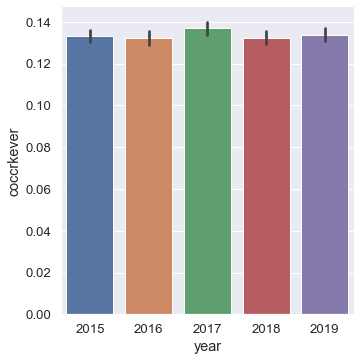

In [57]:
plot = sns.catplot(data=df2_drop, x='year', y='coccrkever', kind='bar', estimator=(lambda x: sum(x)/len(x)), legend=True)

In [65]:
no_values = []
yes_values = []
for year in range(2015, 2020):
    no_values.append(df2_clean.groupby('coccrkever').year.value_counts()[0][year])
    yes_values.append(df2_clean.groupby('coccrkever').year.value_counts()[1][year])

chi_matrix = [no_values, yes_values]
chi_matrix

[[39924, 39460, 39024, 39199, 39006], [6142, 6017, 6190, 5982, 6033]]

In [66]:
significance = 0.05
stat, p, dof, expected = chi2_contingency(chi_matrix)
critical = chi2.ppf(significance, dof)
print("P-value = %f\nChi-Squared Stat = %f\nCritical Value = %f" %(p, stat, critical))

P-value = 0.240431
Chi-Squared Stat = 5.492033
Critical Value = 0.710723


Failed to reject the null hypothesis. So, we can assume the years 2015-2019 have the same distributions

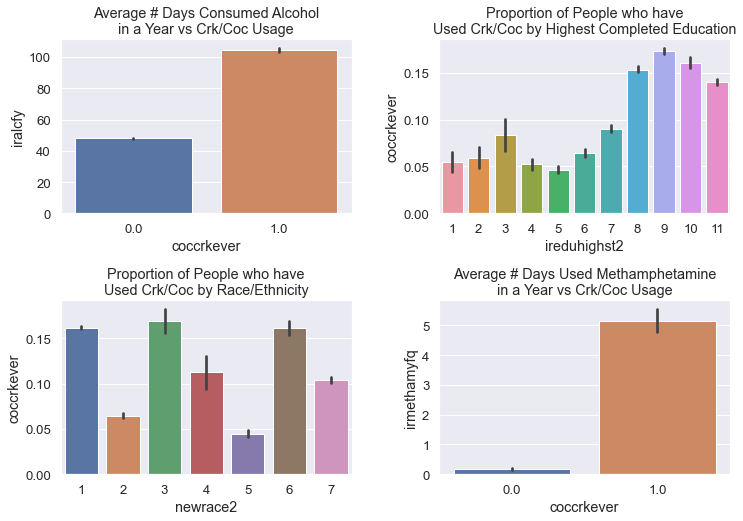

In [93]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.subplot.wspace'] = 0.3
plt.rcParams['figure.subplot.hspace'] = 0.5
fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
sns.barplot(data=df2_clean, x='coccrkever', y='iralcfy',  estimator=(lambda x: sum(x)/len(x)), ax=ax).set_title("Average # Days Consumed Alcohol\nin a Year vs Crk/Coc Usage")

ax = fig.add_subplot(2, 2, 2)
sns.barplot(data=df2_clean, x='ireduhighst2', y='coccrkever',  estimator=(lambda x: sum(x)/len(x)), ax=ax).set_title("Proportion of People who have\nUsed Crk/Coc by Highest Completed Education")

ax = fig.add_subplot(2, 2, 3)
sns.barplot(data=df2_clean, x='newrace2', y='coccrkever',  estimator=(lambda x: sum(x)/len(x)), ax=ax).set_title("Proportion of People who have\nUsed Crk/Coc by Race/Ethnicity")

ax = fig.add_subplot(2, 2, 4)
sns.barplot(data=df2_clean, x='coccrkever', y='irmethamyfq',  estimator=(lambda x: sum(x)/len(x)), ax=ax).set_title("Average # Days Used Methamphetamine\nin a Year vs Crk/Coc Usage")

plt.show()

In [94]:
# Pickle our data
df2_clean.to_pickle("./pickle/NSDUH_cleaned_dropna_2016-2019.pkl")
# df2_clean = pd.read_pickle("./pickle/NSDUH_cleaned_dropna_2016-2019.pkl")